In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble   import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from joblib import dump, load

In [5]:
%matplotlib inline

In [4]:
def precision_recall(recall_l,precision_l,model_name ):
  
    plt.figure(figsize=(15, 6), dpi=80)

    testy = day_test_list[0].Label
    #no_skill = len(testy[testy==1]) / len(testy)
    #plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall_l,precision_l, marker='.', label= model_name)
    # axis labels

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.title( model_name)
    plt.legend(loc="lower right")
    # show the legend
    plt.legend()
    

def test_predict(model, Background_data,day_test_list,feature):
    fpr_l = []
    tpr_l = []
    roc_auc_l = []
    precision_l = []
    recall_l = []
    for day in range(11):
        if day == 0:
            Day_0_test = Background_data[feature]
            X_test = Day_0_test
            #X_test = X_test[ranked_f[:15]].copy()
            X_test = X_test.values
            
            y_test = Background_data.Label.values
            # add random noise to Day 0 (before attack start)
            #a = np.random.uniform(1,113544,100)
            #for i in range(1,100):
            #    y_test[round(a[i])] = 1
            
            y_pred = model.predict(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            preci = precision_score(y_test, y_pred)*100
            recall =  recall_score(y_test, y_pred)*100
            fpr_l.append(fpr)
            tpr_l.append(tpr)
            roc_auc_l.append(roc_auc)
            precision_l.append(preci)
            recall_l.append(recall)
        else:
            #X_test = day_test_list[day - 1 ][day_test_list[ii ].columns[:-1]].values
            X_test = day_test_list[day - 1 ]
            X_test = X_test[feature].copy()
            X_test = X_test.values
            
            y_test = day_test_list[day - 1 ].Label.values 
            y_pred = model.predict(X_test)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            preci = precision_score(y_test, y_pred)
            recall =  recall_score(y_test, y_pred)
            fpr_l.append(fpr)
            tpr_l.append(tpr)
            roc_auc_l.append(roc_auc)
            precision_l.append(preci)
            recall_l.append(recall)
        
    return fpr_l, tpr_l, roc_auc_l , precision_l, recall_l





def features_target_mutual_information_rank(X,y):
    ranked_list = []
   
    features = X.columns
    
    for feature in features:
        if X[feature].max() == X[feature].min():
            X.drop([feature],axis=1,inplace = True)
    
    scaler = StandardScaler()
    scaler.fit(X)
    normalize_data = scaler.transform(X)
    feature_scores = mutual_info_classif(normalize_data, y)
    
    for score, fname in sorted(zip(feature_scores, features), reverse=True)[:]:
        #print(fname, score)
        ranked_list.append((fname, score))
    ranked_f = []
    for i in range(len(ranked_list)):
        ranked_f.append(ranked_list[i][0]) 
    return ranked_f
        

    
def choose_test_type(Background_data,bot_df ):
    
    day_test_list = []
    for i in range(0,10,1):
        rand_state = i + 200
        temp = bot_df.sample(frac=0.1, replace=False, random_state= rand_state)
        if i == 0:
            day_test_list.append(pd.concat([temp, Background_data] ))
        else:
            day_test_list.append(pd.concat([temp, day_test_list[i-1]])) 

    return day_test_list
  

In [139]:
# read training dataset
train = pd.read_table('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\Botnet_Training.csv' ,
                      sep=',' )

In [141]:
# this initial test data set , I will prepare it to suit project problem
test = pd.read_table('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\Botnet_Testing.csv',
               sep=',' )

# Exploratory Data Analysis (EDA) and Data preparation

In [7]:
# the count of target labels
train.Label.value_counts()

Botnet    224210
Normal    131949
Name: Label, dtype: int64

In [9]:
train.head()

,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,59086131.0,8.0,0.0,0.0,0.0,...,0.0,2987276.0,0.0,2987276.0,2987276.0,18700000.0,19500000.0,41100000.0,5999291.0,Normal
1,147.32.84.180,137.0,147.32.84.255,137.0,17.0,12452268.0,38.0,0.0,2476.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Botnet
2,147.32.84.180,1025.0,147.32.80.9,53.0,17.0,118741070.0,6.0,3.0,192.0,660.0,...,8.0,2276383.0,0.0,2276383.0,2276383.0,116000000.0,0.0,116000000.0,116000000.0,Botnet
3,147.32.84.180,1040.0,94.63.149.152,80.0,6.0,180643.0,26.0,10.0,180.0,25790.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Botnet
4,147.32.84.180,1040.0,94.63.149.152,80.0,6.0,440.0,5.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Botnet


In [142]:
# Remove space from feature names
train.columns = train.columns.str.replace(' ','_')
test.columns = test.columns.str.replace(' ','_')

In [143]:
# Rename non-malicius traffic to Backround instead of Normal (no different from data scince perspective, from cybersecurity perspective to be normal should be under control and verfied)
train.replace('Normal', 'Background', inplace= True)
test.replace('Normal', 'Background', inplace= True)

In [144]:
#size of the train data
print(f' The size of the training dataset is: {train.shape}')

 The size of the training dataset is: (356159, 82)


In [145]:
# Checking type of features
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356159 entries, 0 to 356158
Data columns (total 82 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Src_IP             356159 non-null  object 
 1   Src_Port           356159 non-null  float64
 2   Dst_IP             356159 non-null  object 
 3   Dst_Port           356159 non-null  float64
 4   Protocol           356159 non-null  float64
 5   Flow_Duration      356159 non-null  float64
 6   Tot_Fwd_Pkts       356159 non-null  float64
 7   Tot_Bwd_Pkts       356159 non-null  float64
 8   TotLen_Fwd_Pkts    356159 non-null  float64
 9   TotLen_Bwd_Pkts    356159 non-null  float64
 10  Fwd_Pkt_Len_Max    356159 non-null  float64
 11  Fwd_Pkt_Len_Min    356159 non-null  float64
 12  Fwd_Pkt_Len_Mean   356159 non-null  float64
 13  Fwd_Pkt_Len_Std    356159 non-null  float64
 14  Bwd_Pkt_Len_Max    356159 non-null  float64
 15  Bwd_Pkt_Len_Min    356159 non-null  float64
 16  Bw

In [146]:
# the statistics information for the first numric  features 
train.describe().iloc[: , 0:10]

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min
count,356159.000000,356159.000000,356159.000000,3.561590e+05,356159.000000,356159.000000,3.561590e+05,3.561590e+05,356159.000000,356159.000000
mean,10968.844109,3002.240233,8.310297,-9.333955e+07,11.394063,14.693033,7.492795e+02,1.213486e+04,67.722658,10.729332
std,17071.752095,10187.760449,4.565925,6.250101e+10,135.033584,226.601974,3.932825e+04,2.592193e+05,178.685626,26.749719
min,0.000000,0.000000,0.000000,-3.730000e+13,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1754.000000,53.000000,6.000000,1.373800e+04,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3212.000000,80.000000,6.000000,4.931890e+05,3.000000,1.000000,3.200000e+01,0.000000e+00,24.000000,0.000000
75%,7600.000000,80.000000,6.000000,9.011136e+06,6.000000,4.000000,7.600000e+01,4.200000e+02,64.000000,0.000000
max,65535.000000,65535.000000,17.000000,1.200000e+08,15016.000000,29694.000000,6.307840e+06,4.090000e+07,4380.000000,1460.000000


#### some values of for Flow_Duration are negative which is not logical

In [147]:
# any negative values for any features are not logical
#change all negative to positive
train = train.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)
test = test.apply(lambda x: x.abs() if np.issubdtype(x.dtype, np.number) else x)

In [148]:
train.describe().iloc[: , 0:10]

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min
count,356159.000000,356159.000000,356159.000000,3.561590e+05,356159.000000,356159.000000,3.561590e+05,3.561590e+05,356159.000000,356159.000000
mean,10968.844109,3002.240233,8.310297,1.161175e+08,11.394063,14.693033,7.492795e+02,1.213486e+04,67.722658,10.729332
std,17071.752095,10187.760449,4.565925,6.250097e+10,135.033584,226.601974,3.932825e+04,2.592193e+05,178.685626,26.749719
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1754.000000,53.000000,6.000000,1.373950e+04,2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3212.000000,80.000000,6.000000,4.931930e+05,3.000000,1.000000,3.200000e+01,0.000000e+00,24.000000,0.000000
75%,7600.000000,80.000000,6.000000,9.011138e+06,6.000000,4.000000,7.600000e+01,4.200000e+02,64.000000,0.000000
max,65535.000000,65535.000000,17.000000,3.730000e+13,15016.000000,29694.000000,6.307840e+06,4.090000e+07,4380.000000,1460.000000


In [149]:
# the statistics information for the numric features   
train.describe().iloc[: , 10:20]

,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Bytsps,Flow_Pktsps,Flow_IAT_Mean,Flow_IAT_Std
count,356159.000000,356159.000000,356159.000000,356159.000000,356159.000000,356159.000000,3.561580e+05,3.561590e+05,3.561590e+05,3.561590e+05
mean,26.546190,22.675536,306.675819,44.220581,195.699280,105.558209,inf,inf,4.281904e+06,4.868665e+06
std,81.404958,74.843370,537.160515,123.387769,360.786036,217.335619,NaN,NaN,4.017931e+07,1.529869e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.929500e-01,1.007800e+04,0.000000e+00
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.557740e+01,1.245450e+01,1.236720e+05,2.367723e+04
75%,35.000000,21.000000,327.000000,0.000000,192.500000,35.795700,2.706574e+03,1.867239e+02,1.782494e+06,8.355626e+05
max,2470.769200,1397.843600,18980.000000,2920.000000,4439.444400,4305.312500,inf,inf,2.220000e+10,9.130000e+11


#### some features have infinity (inf) for the maximum value

In [151]:
train[train.values == np.inf].shape

(5, 82)

In [152]:
#just five rows have inf value
#very small number, so i will drop them

In [153]:
# drop the rows with inf value
(train == np.inf)
train.drop(train[train.values == np.inf].index, inplace=True)
test.drop(test[test.values == np.inf].index, inplace=True)

In [154]:
# the statistics information for the numric features   
train.describe().iloc[: , 10:20]

,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Bytsps,Flow_Pktsps,Flow_IAT_Mean,Flow_IAT_Std
count,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05
mean,26.546100,22.675727,306.678402,44.220954,195.700929,105.559098,2.965438e+05,1.857459e+04,4.281940e+06,4.868706e+06
std,81.405257,74.843657,537.162040,123.388222,360.787108,217.336318,5.011437e+06,1.092119e+05,4.017948e+07,1.529876e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.929000e-01,1.007875e+04,0.000000e+00
50%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.557705e+01,1.245335e+01,1.236720e+05,2.368441e+04
75%,35.000000,21.000000,327.000000,0.000000,192.500000,35.795700,2.706544e+03,1.867065e+02,1.782494e+06,8.356596e+05
max,2470.769200,1397.843600,18980.000000,2920.000000,4439.444400,4305.312500,2.890000e+08,2.000000e+06,2.220000e+10,9.130000e+11


In [155]:
# the statistics information for the numric features   
train.describe().iloc[: , 20:30]

,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std
count,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05
mean,9.246782e+06,1.080285e+08,1.152373e+08,4.565243e+06,4.824607e+06,8.489496e+06,1.082304e+08,3.548543e+06,8.632013e+05,5.933746e+05
std,2.391927e+07,6.266881e+10,6.250124e+10,4.042026e+07,1.529879e+09,2.342093e+07,6.266881e+10,1.473131e+07,6.777594e+06,3.493174e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.146575e+04,7.000000e+00,2.800000e+01,2.600000e+01,0.000000e+00,2.800000e+01,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.778530e+05,1.470000e+02,2.522665e+05,6.663702e+04,1.541493e+02,1.780145e+05,8.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.006787e+06,1.656550e+04,8.912124e+06,1.782500e+06,4.167894e+05,5.160208e+06,3.470000e+02,1.614348e+05,3.172523e+04,2.442278e+04
max,3.770000e+08,3.740000e+13,3.730000e+13,2.220000e+10,9.130000e+11,3.770000e+08,3.740000e+13,1.200000e+08,1.200000e+08,8.450000e+07


In [156]:
# the statistics information for the numric features   
train.describe().iloc[: , 30:40]

,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pktsps,Bwd_Pktsps
count,3.561560e+05,3.561560e+05,356156.000000,356156.0,356156.0,356156.0,356156.000000,356156.000000,3.561560e+05,356156.000000
mean,2.184748e+06,5.448913e+05,0.029055,0.0,0.0,0.0,237.378722,282.358854,1.831837e+04,256.220077
std,1.011481e+07,6.402956e+06,0.167960,0.0,0.0,0.0,2935.556643,4464.820770,1.092050e+05,1954.188154
min,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,32.000000,0.000000,6.693750e-01,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.0,60.000000,8.000000,6.193050e+00,0.795000
75%,1.104330e+05,7.000000e+00,0.000000,0.0,0.0,0.0,136.000000,72.000000,9.295625e+01,9.239725
max,1.200000e+08,1.200000e+08,1.000000,0.0,0.0,0.0,300880.000000,593888.000000,2.000000e+06,333333.333300


#### some features are constant

In [157]:
# remove constant feature
def remove_no_variance_feature(data):
    features = data.columns
    for feature in features:
        if data[feature].max() == data[feature].min():
            data.drop([feature],axis=1,inplace = True)
    return data

train = remove_no_variance_feature(train)
test = test[train.columns]

In [158]:
train.describe().iloc[: , 30:40]

,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pktsps,Bwd_Pktsps,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean
count,3.561560e+05,3.561560e+05,356156.000000,356156.000000,356156.000000,3.561560e+05,356156.000000,356156.000000,356156.000000,356156.000000
mean,2.184748e+06,5.448913e+05,0.029055,237.378722,282.358854,1.831837e+04,256.220077,10.132756,333.974604,117.553484
std,1.011481e+07,6.402956e+06,0.167960,2935.556643,4464.820770,1.092050e+05,1954.188154,22.472906,546.431962,214.453739
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,32.000000,0.000000,6.693750e-01,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,0.000000e+00,0.000000,60.000000,8.000000,6.193050e+00,0.795000,0.000000,42.000000,16.250000
75%,1.104330e+05,7.000000e+00,0.000000,136.000000,72.000000,9.295625e+01,9.239725,0.000000,406.000000,109.000000
max,1.200000e+08,1.200000e+08,1.000000,300880.000000,593888.000000,2.000000e+06,333333.333300,1450.000000,18980.000000,1456.666700


In [159]:
# the statistics information for the numric features   
train.describe().iloc[: , 40:50]

,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,ECE_Flag_Cnt,DownpUp_Ratio
count,356156.000000,3.561560e+05,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000,356156.000000
mean,138.427587,7.240713e+04,0.023024,0.029055,0.000003,0.386047,0.369919,0.100234,0.000003,0.510863
std,230.748969,1.650581e+05,0.149979,0.167960,0.001676,0.486842,0.482783,0.300312,0.001676,0.674600
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.559300,5.714290e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,158.850300,2.523341e+04,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,2780.491900,7.731135e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,75.000000


In [160]:
# the statistics information for the numric features   
train.describe().iloc[: , 50:60]

,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts
count,356156.000000,356156.000000,356156.000000,356156.000000,3.561560e+05,356156.000000,3.561560e+05,356156.000000,356156.000000,356156.000000
mean,132.114484,26.546100,195.700929,11.394142,7.492852e+02,14.693157,1.213499e+04,26236.408279,6266.525200,2.300315
std,223.650332,81.405257,360.787108,135.034150,3.932841e+04,226.602924,2.592565e+05,26244.169559,15683.956661,35.455436
min,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000e+00,0.000000,0.000000e+00,54.000000,1.000000,0.000000
50%,21.000000,5.000000,0.000000,3.000000,3.200000e+01,1.000000,0.000000e+00,16384.000000,1.000000,0.000000
75%,144.500000,35.000000,192.500000,6.000000,7.600000e+01,4.000000,4.200000e+02,64240.000000,5840.000000,1.000000
max,2185.000000,2470.769200,4439.444400,15016.000000,6.307840e+06,29694.000000,4.092149e+07,65535.000000,65535.000000,5913.000000


In [161]:
train.describe().iloc[: , 60:73]

,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,356156.000000,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05,3.561560e+05
mean,18.408922,4.141822e+05,4.014989e+04,4.577204e+05,3.844982e+05,3.724146e+06,1.982144e+05,3.908964e+06,3.573717e+06
std,6.465465,1.768950e+06,7.468612e+05,2.138641e+06,1.654298e+06,1.433850e+07,2.375563e+06,1.483190e+07,1.414531e+07
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,44.000000,1.150000e+08,6.590000e+07,1.150000e+08,1.150000e+08,1.200000e+08,7.660000e+07,3.770000e+08,1.200000e+08


# Heatmap of correlated features

 removing correlated Features

In [162]:
def drop_corr(train, test):
    X_train = train.iloc[:,:-1]
    y_train = train.Label
    
    correlated_features = set()  
    correlation_matrix = X_train.corr()
    #print(correlation_matrix)
    
    for i in range(len(correlation_matrix .columns)):  
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    
    X_train.drop(labels=correlated_features, axis=1, inplace=True) 
    X_train['Label'] = y_train
    
    train = train[X_train.columns]
    test = test[train.columns]
    return train , test

In [163]:
# remove highly correlated features
train , test = drop_corr(train, test)

### Feature Ranking based on Feature-Target Mutual Information 


In [164]:
# Rank the features based on feature-target Mutual information
X = X_train[X_train.columns[:-1]].copy()
y = y_train.copy()
ranked_f = features_target_mutual_information_rank(X , y)

In [176]:
# the ranked features
ranked_f

['Init_Fwd_Win_Byts',
 'Flow_IAT_Max',
 'Flow_Duration',
 'Dst_Port',
 'Flow_Pktsps',
 'Bwd_Pkt_Len_Max',
 'Fwd_Pkt_Len_Max',
 'TotLen_Fwd_Pkts',
 'Src_Port',
 'Idle_Mean',
 'Bwd_Pktsps',
 'Bwd_Pkt_Len_Min',
 'Init_Bwd_Win_Byts',
 'Flow_Bytsps',
 'Tot_Fwd_Pkts',
 'Bwd_IAT_Tot',
 'Bwd_IAT_Mean',
 'Active_Mean',
 'Bwd_IAT_Std',
 'Protocol',
 'ACK_Flag_Cnt',
 'PSH_Flag_Cnt',
 'DownpUp_Ratio',
 'URG_Flag_Cnt',
 'Fwd_PSH_Flags',
 'Idle_Std',
 'FIN_Flag_Cnt',
 'Active_Std',
 'RST_Flag_Cnt']

In [328]:
#data['Label'] = train.Label.copy()
data = train[].select_dtypes(include='number')
data.columns[1]

'Dst_Port'

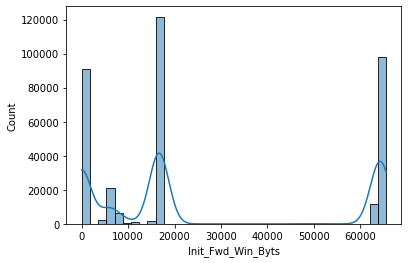

In [182]:
#the histogram for feature that has highest correlation with target
sns.histplot(train[ranked_f[0]],kde=True);

### it is clear that feature has wide range distribution and dose not have normal distribution


C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


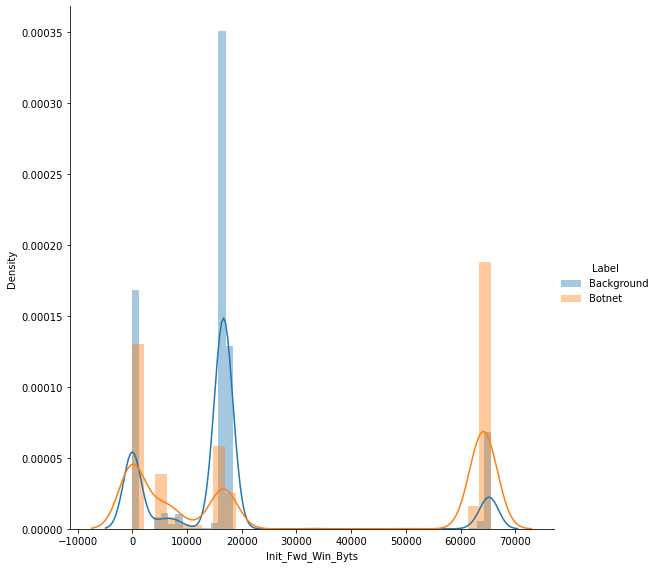

In [190]:
# show the distribution of the taget labels with feature that has the highest correlation with target
sns.FacetGrid(train, hue="Label", height=8) \
   .map(sns.distplot, ranked_f[0]) \
   .add_legend();
plt.show();

#  Botnet types in the training dataset
#### Botnet name | Type |

Neris       | IRC | <br>
Rbot        | IRC |  <br>
Virut       | HTTP |  <br>
NSIS        | P2P |  <br>
SMTP Spam   | P2P |  <br>
Zeus        | P2P | <br>
Zeus control (C & C) | P2P | <br>
Neris       | IRC |  <br>
Rbot        | IRC |  <br>
Virut       | HTTP |  <br>
NSIS        | P2P |  <br>
SMTP Spam   | P2P | <br>
Zeus        | P2P |  <br>
Zeus control (C & C) | P2P |  <br>



In [29]:
X_train = train.copy()

X_train.drop(['Src_IP', 'Dst_IP'], axis =1, inplace= True)
y_train = X_train[X_train.columns[len(X_train.columns) -1 ]]
y_train.replace('Background', 0, inplace = True)
y_train.replace('Botnet', 1, inplace = True)




In [30]:
X_train.shape

(356156, 30)

In [31]:
len(y_train)

356156

# Test Dataset preparation to suit project problem


# Botnet types in the test dataset

#### Botnet name | Type | 
Neris | IRC |  <br>
Rbot | IRC |  <br>
<span style='background :yellow' > Menti | IRC | </span> <br>
<span style='background :yellow' > Sogou | HTTP |  </span> <br>
<span style='background :yellow' > Murlo | IRC |  </span> <br>
Virut | HTTP |  <br>
NSIS | P2P |  <br>
Zeus | P2P |  <br>
SMTP Spam | P2P |  <br>
<span style='background :yellow' >UDP Storm | P2P | </span> <br>
<span style='background :yellow' >Tbot | IRC | </span> <br>
<span style='background :yellow' >Zero Access | P2P |  </span> <br>
<span style='background :yellow' >Weasel | P2P |  </span> <br>
<span style='background :yellow' >Smoke Bot | P2P |  </span> <br>
Zeus Control (C&C) | P2P |  <br>
ISCX IRC bot | P2P |  <br>

In [32]:
botnet_data = test[test.Label == 'Botnet'].copy().reset_index()
botnet_data.drop(['index'] , axis =1, inplace= True)

Background_data = test[test.Label == 'Background'].copy().reset_index()
Background_data.drop(['index'] , axis =1, inplace= True)
Background_data.replace('Background', 0, inplace = True)
Background_data.drop(['Src_IP', 'Dst_IP'], axis =1, inplace= True)

In [33]:

Day_0_test = Background_data.copy()


In [34]:
# size of Background traffic at Day 0
print(f'Size of Background traffic at Day 0:  {Day_0_test.shape} ')

Size of Background traffic at Day 0:  (113545, 30) 


In [35]:

IRC = ['192.168.2.112' , '131.202.243.84' 
       ,'192.168.5.122' , '198.164.30.2' 
       , '192.168.2.110' , '192.168.5.122'
       , '192.168.4.118' , '192.168.5.122'
       , '192.168.2.113' , '192.168.5.122'
       , '192.168.1.103' , '192.168.5.122'
       , '192.168.4.120' , '192.168.5.122'
       , '192.168.2.112' , '192.168.2.110'
       , '192.168.2.112' , '192.168.4.120'
       , '192.168.2.112' , '192.168.1.103'
       , '192.168.2.112' , '192.168.2.113'
       , '192.168.2.112' , '192.168.4.118'
       , '192.168.2.112' , '192.168.2.109'
       , '192.168.2.112' , '192.168.2.105'
       , '192.168.1.105' , '192.168.5.122']
Neris = ['147.32.84.180']
RBot =  ['147.32.84.170']
Menti = ['147.32.84.150']
Sogou = ['147.32.84.140']
Murlo = ['147.32.84.130']
Virut = ['147.32.84.160']
IRCbot = ['10.0.2.15'] 
black_hole_1 = ['10.0.2.15']
Black_hole_2 = ['192.168.106.141']
Black_hole_3 = ['192.168.106.131']
TBot = ['172.16.253.130', '172.16.253.131', '172.16.253.129', '172.16.253.240']
Weasel = ['74.78.117.238', '158.65.110.24']
Zeus = ['192.168.3.35', '192.168.3.25', '192.168.3.65', '172.29.0.116']
Osx_trojan = ['172.29.0.109']
Zero_access = ['172.16.253.132', '192.168.248.165']
Smoke_bot = ['10.37.130.4']

In [36]:
bot_list = [IRC, Neris ,Menti ,Sogou , Murlo , Virut ,  IRCbot  , black_hole_1
            ,  Black_hole_2  , Black_hole_3 , TBot  , Weasel , Zeus , Osx_trojan 
            , Zero_access  , Smoke_bot]

In [37]:
bot_df = []
for i in bot_list:
    temp_df = botnet_data[botnet_data['Src_IP'].isin(i) | botnet_data['Dst_IP'].isin(i)].copy().reset_index()
    bot_df.append(temp_df)
for i in range(0,16):
    bot_df[i].drop(['index'] , axis =1, inplace= True)
    bot_df[i].replace('Botnet', 1, inplace = True)
    bot_df[i].drop(['Src_IP', 'Dst_IP'], axis =1, inplace= True)
#Menti_df = botnet_data[botnet_data['Src IP'].isin(Menti) | botnet_data['Dst IP'].isin(Menti)].copy().reset_index()

Size of botnet varints (will be employed in test dataset)

In [38]:
bot_dic = {0 :'IRC', 1: 'Neris' ,2 : 'Menti' ,3 : 'Sogou' , 4 : 'Murlo' , 5 : 'Virut' ,  6 : 'IRCbot'  , 7: 'black_hole_1'
            , 8: 'Black_hole_2'  , 9: 'Black_hole_3' , 10 : 'TBot'  , 11 : 'Weasel' , 12 : 'Zeus' , 13 : 'Osx_trojan' 
            , 14 : 'Zero_access'  , 15 : 'Smoke_bot'}
for i in range(0,16):
    print(f'size of {bot_dic[i]} {i} is:   {bot_df[i].shape[0]}')

size of IRC 0 is:   18592
size of Neris 1 is:   26663
size of Menti 2 is:   4970
size of Sogou 3 is:   82
size of Murlo 4 is:   12946
size of Virut 5 is:   42725
size of IRCbot 6 is:   45
size of black_hole_1 7 is:   45
size of Black_hole_2 8 is:   445
size of Black_hole_3 9 is:   257
size of TBot 10 is:   967
size of Weasel 11 is:   85502
size of Zeus 12 is:   424
size of Osx_trojan 13 is:   27
size of Zero_access 14 is:   1700
size of Smoke_bot 15 is:   84


### only Weasel will be used in test datasets , the other will be dropped

###  Finding Optimal hyperparameters  for  DecisionTreeClassifier

In [397]:
feature = ranked_f[:].copy()
X_train1 = X_train[feature].copy()
X = X_train1.values
y = y_train.values

In [179]:
param_dist = {"max_depth": randint(30, 90),
              "min_samples_leaf": randint(1, 15 ),
              "criterion": ["gini", "entropy"]}


In [180]:
cl = DecisionTreeClassifier() 

In [185]:
# Instantiate the random search
rand_search = RandomizedSearchCV(estimator=cl, 
                           param_distributions=param_dist, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "precision",  n_iter=100, random_state=10)



In [186]:
%%time
rand_search.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 15min 37s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EC35853D90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EC358D4280>},
                   random_state=10, scoring='precision', verbose=1)

In [187]:
model = rand_search
dump(model, 'DecisionTree' )

['DecisionTree_smote']

### DecisionTreeClassifier Evaluation with unseen test dataset

In [271]:
#size of IRC 0 is:   18592
#size of Neris 1 is:   26663
#size of Menti 2 is:   4970
#size of Sogou 3 is:   82
#size of Murlo 4 is:   12946
#size of Virut 5 is:   42725
#size of IRCbot 6 is:   45
#size of black_hole_1 7 is:   45
#size of Black_hole_2 8 is:   445
#size of Black_hole_3 9 is:   257
#size of TBot 10 is:   967
#size of Weasel 11 is:   85502
#size of Zeus 12 is:   424
#size of Osx_trojan 13 is:   27
#size of Zero_access 14 is:   1700
#size of Smoke_bot 15 is:   84

day_test_list = choose_test_type(Background_data.copy(), bot_df[11]  )


(84, 30)


In [97]:
fpr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model1 ,Background_data.copy(),day_test_list,feature)



In [98]:
model_mame = 'DecisionTree'
#plot_roc(fpr_l,tpr_l,roc_auc_l, model_mame)

In [162]:
model = load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\DecisionTree')


In [163]:
model.best_score_*100

84.6401570727084

In [173]:
fpr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model ,Background_data.copy(),day_test_list,feature)

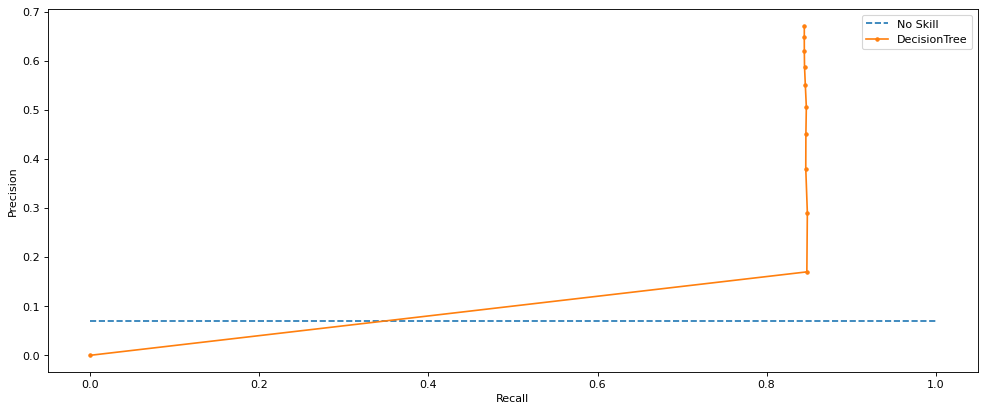

In [165]:
model_name = 'DecisionTree'
precision_recall_curves(recall_l,precision_l,model_name )

### BalancedRandomForestClassifier Evaluation with unseen test dataset

In [217]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [52]:
feature = ranked_f[:].copy()

In [ ]:

X_train1 = X_train[feature].copy()
X = X_train1.values
y = y_train.values

In [228]:
param_dist = {"max_depth": randint(2, 15),
              "criterion": ["gini", "entropy"]}



In [229]:
clf = BalancedRandomForestClassifier( random_state=0)
 

In [230]:

# Instantiate the random search
rand_search = RandomizedSearchCV(estimator=cl, 
                           param_distributions=param_dist, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "precision",  n_iter=100, random_state=10)



In [231]:
%%time
rand_search.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Wall time: 6min 34s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001EC922F3E20>},
                   random_state=10, scoring='precision', verbose=1)

In [281]:
model.best_score_*100

91.79554074760969

In [ ]:
#ssave the BalancedRandomForest model
model = rand_search
dump(model, 'BalancedRandomForest' )

In [111]:
model = load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\BalancedRandomForest')


In [172]:
fpr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model ,Background_data.copy(),day_test_list,feature)

### BalancedRandomForestr Evaluation with unseen test dataset

In [64]:
#size of IRC 0 is:   18592
#size of Neris 1 is:   26663
#size of Menti 2 is:   4970
#size of Sogou 3 is:   82
#size of Murlo 4 is:   12946
#size of Virut 5 is:   42725
#size of IRCbot 6 is:   45
#size of black_hole_1 7 is:   45
#size of Black_hole_2 8 is:   445
#size of Black_hole_3 9 is:   257
#size of TBot 10 is:   967
#size of Weasel 11 is:   85502
#size of Zeus 12 is:   424
#size of Osx_trojan 13 is:   27
#size of Zero_access 14 is:   1700
#size of Smoke_bot 15 is:   84

day_test_list = choose_test_type(Background_data.copy(), bot_df[11]  )



In [171]:
pr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model ,Background_data.copy(),day_test_list,feature)
    

In [114]:
model_mame = 'BalancedRandomForest'
#plot_roc(fpr_l,tpr_l,roc_auc_l, model_mame)

In [54]:
from sklearn.metrics import precision_recall_curve

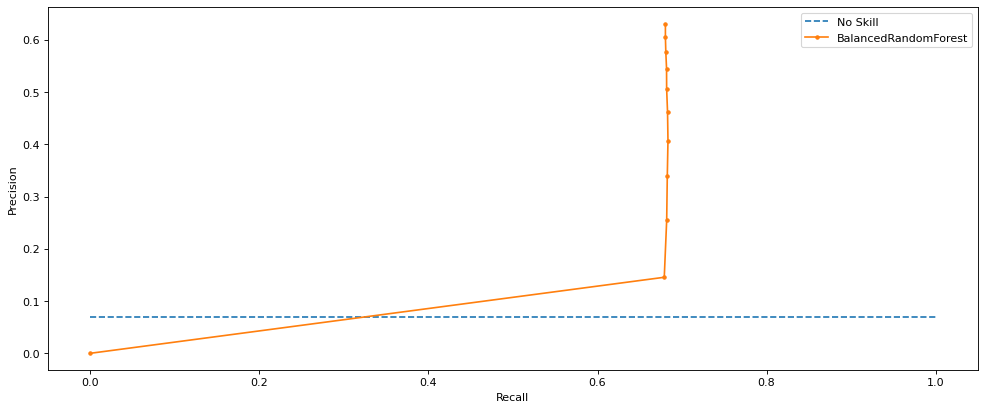

In [115]:
model_name = 'BalancedRandomForest'
precision_recall_curves(recall_l,precision_l,model_name )

###  Finding Optimal hyperparameters  for  Logistic Regression

In [123]:
feature = ranked_f[:].copy()
X_train1 = X_train[feature].copy()
X = X_train1.values
y = y_train.values

In [147]:
param_dist = {"C": randint(0.1, 1)}


In [148]:


cl = LogisticRegression()


In [149]:
stc = StandardScaler()
stc.fit(X)
X_trans = stc.transform(X)

In [150]:
# Instantiate the random search
rand_search = RandomizedSearchCV(estimator=cl, 
                           param_distributions=param_dist, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "precision",  n_iter=100, random_state=10)



In [151]:
%%time
rand_search.fit(X_trans,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "C:\Users\Meshal\anaconda3\envs\metis\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(

ZeroDivisionError: float division by zero

In [134]:
model = rand_search
dump(model, 'Logistic Regression' )

['Logistic Regression']

In [157]:
model.best_score_*100

75.86093554313172

### Logistic Regression Evaluation with unseen test dataset

In [42]:
#size of IRC 0 is:   18592
#size of Neris 1 is:   26663
#size of Menti 2 is:   4970
#size of Sogou 3 is:   82
#size of Murlo 4 is:   12946
#size of Virut 5 is:   42725
#size of IRCbot 6 is:   45
#size of black_hole_1 7 is:   45
#size of Black_hole_2 8 is:   445
#size of Black_hole_3 9 is:   257
#size of TBot 10 is:   967
#size of Weasel 11 is:   85502
#size of Zeus 12 is:   424
#size of Osx_trojan 13 is:   27
#size of Zero_access 14 is:   1700
#size of Smoke_bot 15 is:   84

day_test_list = choose_test_type(Background_data.copy(), bot_df[11]  )


In [169]:
fpr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model1 ,Background_data.copy(),day_test_list,feature)

In [156]:
model_mame = 'Logistic Regression'
#plot_roc(fpr_l,tpr_l,roc_auc_l, model_mame)

In [143]:
model = load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\Logistic Regression')


In [170]:
fpr_l, tpr_l, roc_auc_l , precision_l, recall_l = test_predict(model ,Background_data.copy(),day_test_list,feature)

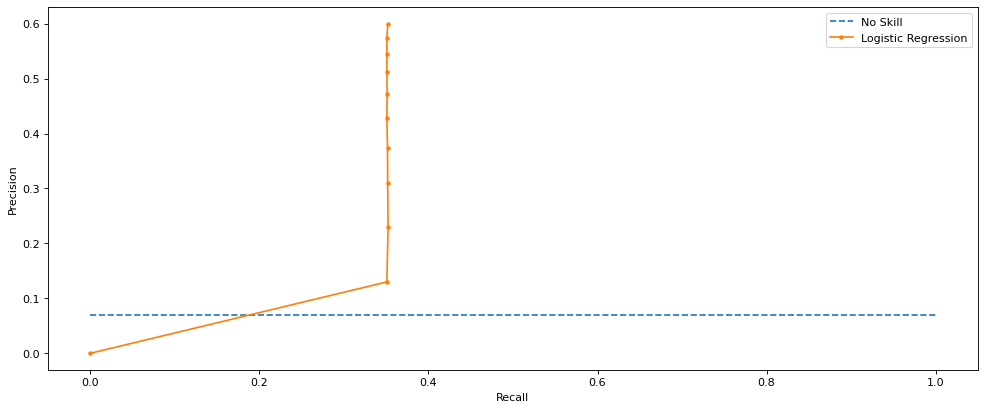

In [146]:
model_name = 'Logistic Regression'
precision_recall(recall_l,precision_l,model_name )

### Draw all model evaluations in one graph

In [44]:
feature = ranked_f[:].copy()

In [166]:
model_name1 = 'DecisionTree'
model1 = load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\DecisionTree')
fpr_l, tpr_l, roc_auc_l , precision_l1, recall_l1 = test_predict(model1 ,Background_data.copy(),day_test_list,feature)

In [167]:
model_name2 = 'BalancedRandomForest'
model2 = model = load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\BalancedRandomForest')
fpr_l, tpr_l, roc_auc_l , precision_l2, recall_l2 = test_predict(model2 ,Background_data.copy(),day_test_list,feature)

In [168]:
model_name3 = 'Logistic Regression'
model3= load('C:\\Users\\Meshal\\Documents\\UP\\Data_Science_Bootcamps\\Project\\Botnet_Dataset\\Logistic Regression')
fpr_l, tpr_l, roc_auc_l , precision_l3, recall_l3 = test_predict(model3 ,Background_data.copy(),day_test_list,feature)

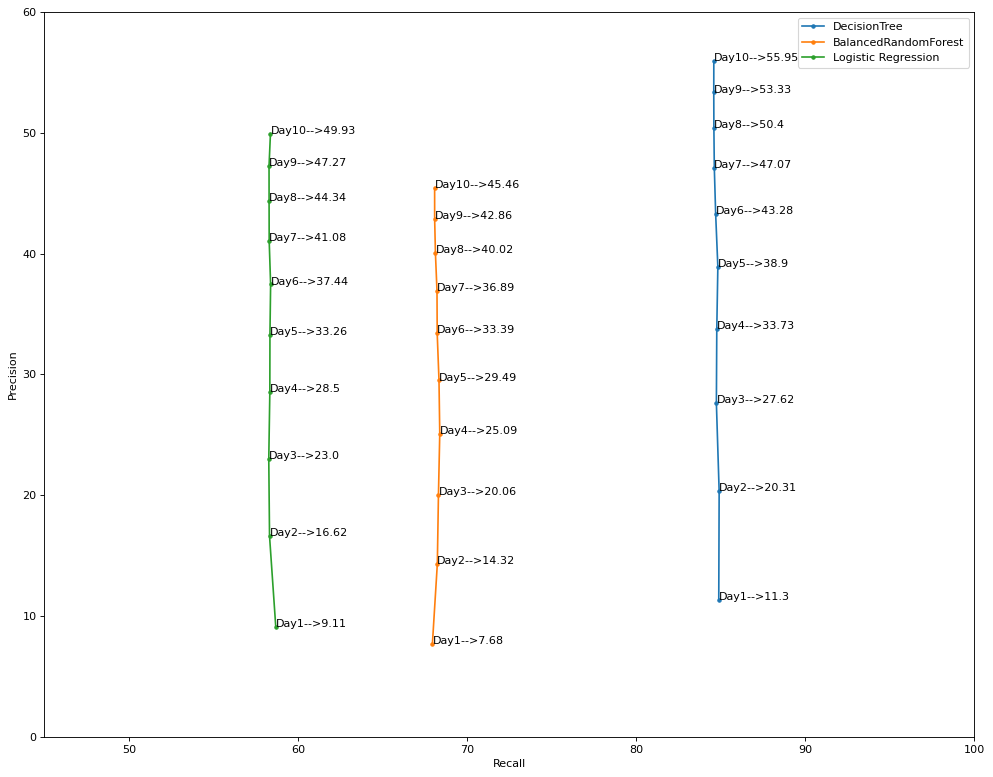

In [138]:

  
plt.figure(figsize=(15, 12), dpi=80)

plt.xlim(45, 100)
plt.ylim(0, 60)

testy = day_test_list[0].Label
no_skill = len(testy[testy==1]) / len(testy)
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(np.array(recall_l1[1:])*100,np.array(precision_l1[1:])*100, marker='.', label= model_name1)
for i in range(1,11):
    plt.annotate("Day"+str(i)+'-->'+str(round(np.array(precision_l1[i])*100,2)), (np.array(recall_l1[i])*100,np.array(precision_l1[i])*100))

plt.plot(np.array(recall_l2[1:])*100,np.array(precision_l2[1:])*100, marker='.', label= model_name2)
for i in range(1,11):
    plt.annotate("Day"+str(i)+'-->'+str(round(np.array(precision_l2[i])*100,2)), (np.array(recall_l2[i])*100,np.array(precision_l2[i])*100))

plt.plot(np.array(recall_l3[1:])*100,np.array(precision_l3[1:])*100, marker='.', label= model_name3)
for i in range(1,11):
    plt.annotate("Day"+str(i)+'-->'+str(round(np.array(precision_l3[i])*100,2)), (np.array(recall_l3[i])*100,np.array(precision_l3[i])*100))



plt.xlabel('Recall')
plt.ylabel('Precision')
    
)
plt.legend();
